In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from IPython.display import clear_output

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, TimeDistributed

In [3]:
# Let's try to compress sequences of packet_len values using an autoencoder
# Will reduce a sequence of say 50 values into a sequence of 5 values that we can use to reduce randomness in the data

In [119]:
# Import old stuff
class DataPoint():
    def __init__(self, x, y):
        self.x = x
        self.y = y
    
    def __getitem__(self, key):
        return DataPoint(self.x[key], self.y[key])
    
    def __repr__(self):
        return "DataPoint(%s, %s)" % (self.x, self.y)

class DataPoints():
    def __init__(self, x=[], y=[]):
        self.x = np.array(x)
        self.y = np.array(y)
        
    def __copy__(self):
        return DataPoints(self.x, self.y)
        
    def __getitem__(self, key):
        return DataPoint(self.x[key], self.y[key])
    
    def __repr__(self):
        return str([DataPoint(self.x[i], self.y[i]) for i, _ in enumerate(self.x)])
    
    def __len__(self):
        return len(self.x)
        
    def append(self, x, y):
        self.x = np.append(self.x, x)
        self.y = np.append(self.y, y)
    
    def addPoints(self, x=[], y=[]):
        self.x += x
        self.y += y
        
    def copy(self):
        return DataPoints(list(self.x), list(self.y))
        
    def insert(self, x, y, index):
        self.x = np.insert(self.x, index, x)
        self.y = np.insert(self.y, index, y)
    
    def remove(self, index):
        self.x = np.delete(self.x, index)
        self.y = np.delete(self.y, index)
        
    def __iter__(self):
        return iter([[self.x[i], self.y[i]] for i, x in enumerate(self.x)])
    
def get_packets_and_bandwidths(filename, time_interval=1, addr_to_ignore=['192.168.8.1', '192.168.8.255']):
    print("Reading CSV...", end="\r", flush=True)
    data = pd.read_csv(filename)
    print("              ", end="\r", flush=True)
    
    packets = {}
    i = 0
    for _, row in data.iterrows():
        i = i + 1
        print("%.2f%%" % ((i / data.shape[0]) * 100), end="\r", flush=True) if i % 1000 == 0 else None
        addr = row['Destination']
        if '192.168' not in addr or addr in addr_to_ignore:
            continue

        if addr in packets:
            packets[addr].append(row)
        else:
            packets[addr] = [row]
            
    bandwidth_output = extract_bandwidths(packets, time_interval)
            
    print("Bandwidth extraction complete.")
    return data, packets, bandwidth_output

def extract_bandwidths(packets, time_interval=1):
    bandwidths = {}
    print("Calcualting bwidths...", end = "\r")
    
    total_packets = np.sum([len(packets[addr]) for addr in packets])
    i = 0
    print("                       ", end = "\r")
    
    bandwidth_output = {}
    for addr in packets:
        if addr not in bandwidths:
            bandwidths[addr] = {}

        for packet in packets[addr]:
            i += 1
            print("%.2f%%" % ((i / total_packets) * 100), end="\r", flush=True) if i % 10000 == 0 else None
            time_clump = (packet['Time'] // time_interval) * time_interval # trick to round to nearest time_interval
            if time_clump in bandwidths[addr]:
                bandwidths[addr][time_clump] += packet['Length']
            else:
                bandwidths[addr][time_clump] = 0
        
        bandwidth_x = [x for x in sorted(bandwidths[addr].keys())]
        bandwidth_y = [bandwidths[addr][x] for x in bandwidth_x]
        bandwidth_output[addr] = DataPoints(bandwidth_x, bandwidth_y)
    print("Calculation complete.     ", end="\r")
    return bandwidth_output

def fill_empty_time_values(input_bandwidths=DataPoints(), addrs=[], time_interval=1):
    print("Filling empty values..", end="\r")
    if len(addrs) == 0:
        addrs = list(input_bandwidths.keys())
        
    bandwidths = {}
    for addr in addrs:
        bandwidths[addr] = input_bandwidths[addr].copy()
        
        time_values = np.linspace(0, max(bandwidths[addr].x), int(max(bandwidths[addr].x) / time_interval), endpoint=False)
        for time_value in time_values:
            print("%.2f%%                   " % (time_value/time_values[-1]*100), end="\r")
            if time_value not in bandwidths[addr].x:
                bandwidths[addr].append(time_value, 0)
                
        bandwidths[addr].x, bandwidths[addr].y = np.array(list(zip(*sorted(zip(bandwidths[addr].x, bandwidths[addr].y)))))
        print("Finished filling addr:", addr)
        
    print("Filled values             ")
    return bandwidths

def next_batch(datasets=[], batch_sz=10, forecast=1, pad_with_zeros=False):
    # Select a random dataset to choose from
    dataset_index = int(np.random.uniform(0, len(datasets)))
    dataset = datasets[dataset_index]
    
    # Select a random starting point. Make sure there is enough room to form a batch after it 
    start_point = int(np.random.uniform(0, len(dataset)-batch_sz-forecast))
    
    # x_batch is the batch_sz from the starting point
    # y_batch is the x_batch shifted by an amount of forecast
    x_batch = dataset[start_point:start_point+batch_sz].reshape(-1, batch_sz, 1)
    y_batch = dataset[start_point+forecast:start_point+batch_sz+forecast].reshape(-1, batch_sz, 1)
    
    if pad_with_zeros:
        y_batch = dataset[start_point+batch_sz:start_point+batch_sz+forecast]
        y_batch = np.append(np.zeros(batch_sz-forecast), y_batch).reshape(-1, batch_sz, 1)
    
    # ts is the whole batch (from the start of x_batch to the end of y_batch)
    ts = dataset[start_point:start_point+batch_sz+forecast]
    return x_batch, y_batch, ts

def bandwidths_to_sequences(dataset, train_test_ratio=1.0, include_times=True):
    input_data = []# [ [time_since_last_packet, length] ]

    if include_times:
        for i, _ in enumerate(dataset):
            if i == 0:
                input_data.append([dataset[i].x, dataset[i].y])
            else:
                input_data.append([1000*(dataset[i].x-dataset[i-1].x), dataset[i].y])
    else:
        for i, _ in enumerate(dataset):
            input_data.append([dataset[i].y])

    input_data = np.array(input_data)
    
    seq_len = 30
    x_data = []

    for i, val in enumerate(input_data):
        if i % 5 == 0 and i+seq_len < len(input_data):
            x_data.append(input_data[i:i+seq_len])

    x_data = np.array(x_data)
    x_data.shape # 20888 samples, 30 time steps, 2 features
    
    x_data_train = x_data[0:int(len(x_data)*train_test_ratio)]
    if train_test_ratio < 1:
        x_data_test = x_data[int(len(x_data)*train_test_ratio):]
    else:
        x_data_test = []
        
    return x_data, x_data_train, x_data_test

class PlotLosses(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        
        self.fig = plt.figure()
        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):
        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, self.losses, label="loss")
        plt.plot(self.x, self.val_losses, label="val_loss")
        plt.legend()
        plt.show();
        
plot_losses = PlotLosses()

# Import Data

In [66]:
data1b, packets1b, bandwidths1b = get_packets_and_bandwidths('YoutubeTests1.csv', time_interval=.001)

Bandwidth extraction complete.


In [120]:
data2b, packets2b, bandwidths2b = get_packets_and_bandwidths('YoutubeTests2.csv', time_interval=.001)

Bandwidth extraction complete.


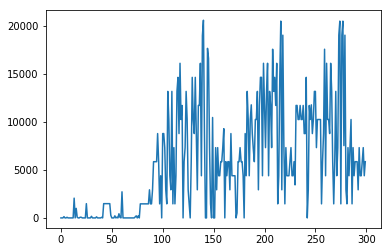

In [37]:
plt.plot(bandwidths2b['192.168.8.237'].y[:300])
plt.show()

In [92]:
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([1000*dataset[i].x, dataset[i].y])
    else:
        input_data.append([1000*(dataset[i].x-dataset[i-1].x), dataset[i].y])

input_data = np.array(input_data)

In [93]:
seq_len = 30
x_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])

x_data = np.array(x_data)
x_data.shape # 20888 samples, 30 time steps, 2 features

(20888, 30, 2)

In [94]:
x_data_train = x_data[:14621]
x_data_test = x_data[14621:]
x_data_train.shape

(14621, 30, 2)

# Simple RNN Matching

In [95]:
autoencoder = Sequential()
autoencoder.add(LSTM(units=seq_len, activation='relu', input_shape=(30, 2), return_sequences=True, name="layer1"))
autoencoder.add(TimeDistributed(Dense(2), name="layer4"))

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3960      
_________________________________________________________________
layer4 (TimeDistributed)     (None, 30, 2)             62        
Total params: 4,022
Trainable params: 4,022
Non-trainable params: 0
_________________________________________________________________


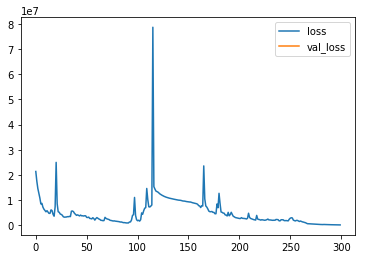

In [96]:
autoencoder.fit(x_data_train, x_data_train, batch_size=200, epochs=300, verbose=1, callbacks=[plot_losses])

In [101]:
sample = x_data_test[300]
results = autoencoder.predict(np.array([sample]))

In [102]:
timesResult = []
bwResult = []
for time_step in results[0]:
    timesResult.append(time_step[0])
    bwResult.append(time_step[1])

for i, x in enumerate(timesResult):
    if i != 0:
        timesResult[i] += timesResult[i-1]
        
timesTest = []
bwTest = []
for i, x in enumerate(sample):
    if i == 0:
        timesTest.append(sample[i][0])
    else:
        timesTest.append(sample[i][0] + timesTest[i-1])
        
    bwTest.append(sample[i][1])

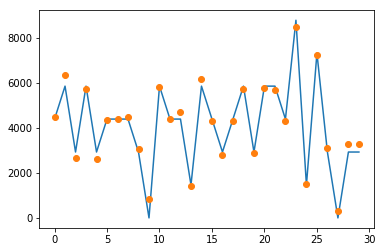

In [103]:
plt.plot(bwTest)
plt.plot(bwResult, 'o')
plt.show()

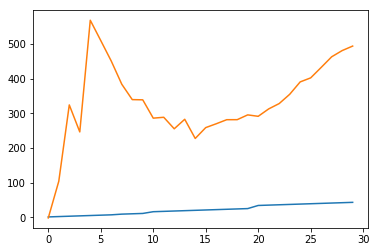

-309.55291207647645

In [106]:
plt.plot(timesTest)
plt.plot(timesResult)
plt.show()

np.mean(np.array(timesTest).flatten() - np.array(timesResult).flatten())

## Results
In this test, using an LSTM to estimate the next packet's length and interpacket time showed that the RNN was extremely successful in targeting the next packet's length, but was less successful in predicting the interpacket time

We will now try to do the same test, but without including interpacket time

# Simple RNN Matching 
### Without Interpacket Times

In [555]:
# Organize data
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([dataset[i].y])
    else:
        input_data.append([dataset[i].y])

input_data = np.array(input_data)

In [556]:
seq_len = 30
x_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])

x_data = np.array(x_data)
x_data.shape # 20888 samples, 30 time steps, 2 features

(20888, 30, 1)

In [557]:
x_data_train = x_data[:14621]
x_data_test = x_data[14621:]

In [558]:
# Setup RNN
rnn = Sequential()
rnn.add(LSTM(units=seq_len, activation='relu', input_shape=(30, 1), return_sequences=True, name="layer1"))
rnn.add(TimeDistributed(Dense(1), name="layer4"))

rnn.compile(loss='mean_squared_error', optimizer='adam')
rnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
layer4 (TimeDistributed)     (None, 30, 1)             31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


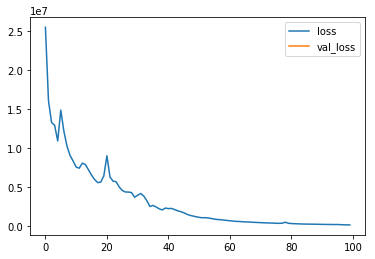

In [559]:
rnn.fit(x_data_train, x_data_train, batch_size=200, epochs=100, verbose=1, callbacks=[plot_losses], shuffle=True)

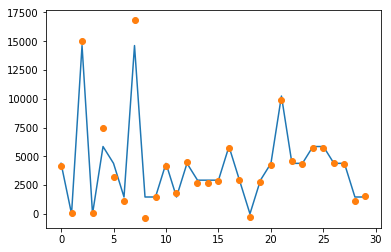

In [564]:
sample = x_data_test[1000]
results = rnn.predict(np.array([sample]))

plt.plot(sample.flatten())
plt.plot(results.flatten(), 'o')
plt.show()

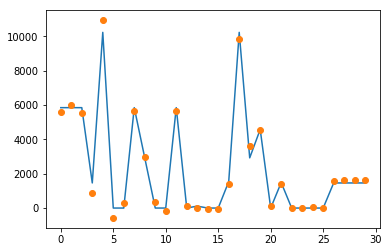

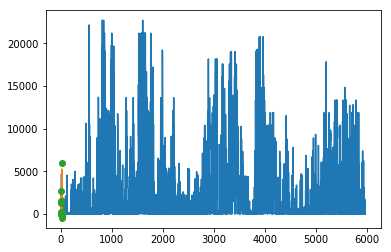

In [630]:
# ANOTHER VIDEO SAMPLE
data, train_data, test_data = bandwidths_to_sequences(bandwidths1b['192.168.8.237'], include_times=False)
test_sample = data[100]
test_results = rnn.predict(np.array([test_sample]))

plt.plot(test_sample.flatten())
plt.plot(test_results.flatten(), 'o')
plt.show()

# NON VIDEO SAMPLE
data, train_data, test_data = bandwidths_to_sequences(bandwidths1b['192.168.8.180'], include_times=False)
test_sample = data[500]
test_results = rnn.predict(np.array([test_sample]))

plt.plot(bandwidths1b['192.168.8.180'].y)
plt.plot(test_sample.flatten())
plt.plot(test_results.flatten(), 'o')
plt.show()

# Predicting Future Values

In [128]:
# Organize data
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([dataset[i].y])
    else:
        input_data.append([dataset[i].y])

input_data = np.array(input_data)

In [129]:
seq_len = 30
forecast = 10
x_data = []
y_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])
        y_data.append(input_data[i+forecast:i+seq_len+forecast])

x_data = np.array(x_data[:-2])
y_data = np.array(y_data[:-2])
y_data.shape # 20888 samples, 30 time steps, 1 feature

(20886, 30, 1)

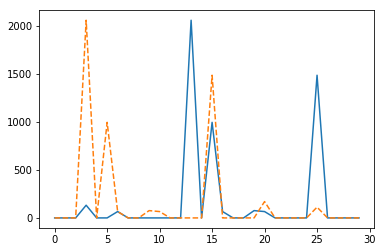

In [130]:
plt.plot(x_data[0])
plt.plot(y_data[0], '--')

In [131]:
x_data_train = x_data[:14621]
y_data_train = y_data[:14621]

x_data_test = x_data[14621:]
y_data_test = y_data[14621:]

In [125]:
# Setup RNN
model = Sequential()
model.add(LSTM(units=seq_len, activation='relu', input_shape=(30, 1), return_sequences=True, name="layer1"))
model.add(TimeDistributed(Dense(1), name="layer4"))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
layer4 (TimeDistributed)     (None, 30, 1)             31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


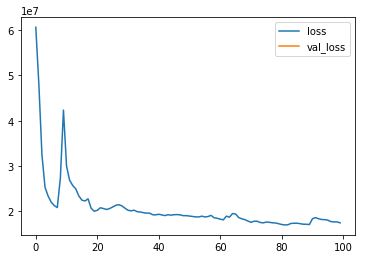

In [126]:
model.fit(x_data_train, y_data_train, batch_size=400, epochs=100, verbose=1, callbacks=[plot_losses], shuffle=True)


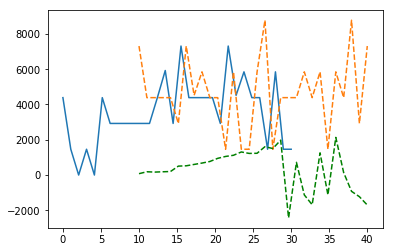

In [246]:
# Good picks = 500, 
i = 5000
sample = x_data_test[i]
sampleY = y_data_test[i]
results = model.predict(np.array([sample]))

sampleX = np.linspace(0, 30, 30)
resultX = np.linspace(10, 40, 30)
plt.plot(sampleX, sample.flatten())
plt.plot(resultX, sampleY.flatten(), '--')
plt.plot(resultX, results.flatten(), 'g--')
plt.show()

# Predict Further

In [235]:
# Organize data
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([dataset[i].y])
    else:
        input_data.append([dataset[i].y])

input_data = np.array(input_data)

In [252]:
seq_len = 30
forecast = 20
x_data = []
y_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len+forecast < len(input_data):
        x_data.append(input_data[i:i+seq_len])
        y_data.append(input_data[i+forecast:i+seq_len+forecast])

x_data = np.array(x_data[:-2])
y_data = np.array(y_data[:-2])
y_data.shape # 20888 samples, 30 time steps, 1 feature

x_data_train = x_data[:14621]
y_data_train = y_data[:14621]

x_data_test = x_data[14621:]
y_data_test = y_data[14621:]

print(x_data_train.shape, y_data_train.shape)

(14621, 30, 1) (14621, 30, 1)


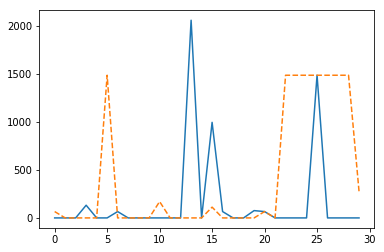

In [253]:
plt.plot(x_data[0])
plt.plot(y_data[0], '--')

In [260]:
# Setup RNN
model2 = Sequential()
model2.add(LSTM(units=seq_len, activation='relu', input_shape=(seq_len, 1), return_sequences=True, name="layer1"))
model2.add(TimeDistributed(Dense(1), name="layer4"))

model2.compile(loss='mean_squared_error', optimizer='adam')
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3840      
_________________________________________________________________
layer4 (TimeDistributed)     (None, 30, 1)             31        
Total params: 3,871
Trainable params: 3,871
Non-trainable params: 0
_________________________________________________________________


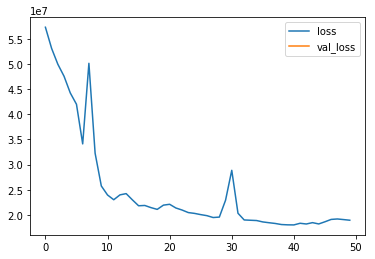

In [261]:
model2.fit(x_data_train, y_data_train, batch_size=400, epochs=50, verbose=1, callbacks=[plot_losses], shuffle=True)


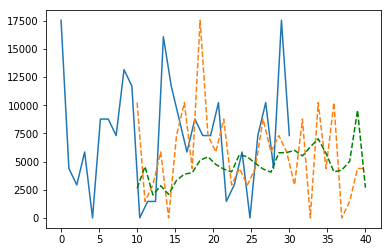

1075.8462961083233


In [294]:
# Good picks = 500, 
i = 500
sample = x_data_test[i]
sampleY = y_data_test[i]
results = model2.predict(np.array([sample]))

sampleX = np.linspace(0, 30, 30)
resultX = np.linspace(10, 40, 30)
plt.plot(sampleX, sample.flatten())
plt.plot(resultX, sampleY.flatten(), '--')
plt.plot(resultX, results.flatten(), 'g--')
plt.show()

np.mean(np.array(sampleY) - np.array(results))

sumVal = 0
count = 0
for i in range(len(x_data_test)):
    sample = x_data_test[i]
    sampleY = x_data_test[i]
    results = model2.predict(np.array([sample]))
    sumVal += np.mean(np.array(sampleY) - np.array(results))
    count += 1

print(sumVal / count)

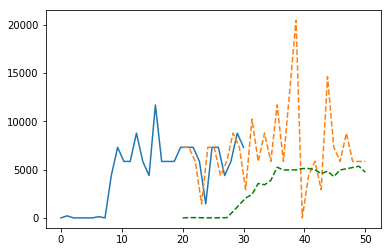

4098.7751908838745


In [290]:
testX, testY, _ = next_batch([bandwidths1b['192.168.8.237'].y], batch_sz=seq_len, forecast=forecast)
result = model2.predict([testX])

sampleX = np.linspace(0, seq_len, seq_len)
resultX = np.linspace(forecast, seq_len+forecast, seq_len)
plt.plot(sampleX, testX.flatten())
plt.plot(resultX, testY.flatten(), '--')
plt.plot(resultX, result.flatten(), 'g--')
plt.show()
print(np.mean(testY - result))



### Results
It seems like it gives reasonable prediction values, but might gives a value that leans towards the average

### What happens when we let it look further back?

In [14]:
# Organize data
data2b, packets2b, bandwidths2b = get_packets_and_bandwidths('YoutubeTests2.csv', time_interval=.001)
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([dataset[i].y])
    else:
        input_data.append([dataset[i].y])

input_data = np.array(input_data)

Bandwidth extraction complete.


In [15]:
seq_len = 10
forecast = 10
x_data = []
y_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])
        y_data.append(input_data[i+forecast:i+seq_len+forecast])

x_data = np.array(x_data[:-2])
y_data = np.array(y_data[:-2])
y_data.shape # 20888 samples, 30 time steps, 1 feature

x_data_train = x_data[:14621]
y_data_train = y_data[:14621]

x_data_test = x_data[14621:]
y_data_test = y_data[14621:]

In [16]:
# Setup RNN
forecast2 = Sequential()
forecast2.add(LSTM(units=seq_len, activation='relu', input_shape=(seq_len, 1), return_sequences=True, name="layer1"))
forecast2.add(TimeDistributed(Dense(1), name="layer4"))

forecast2.compile(loss='mean_squared_error', optimizer='adam')
forecast2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 10, 10)            480       
_________________________________________________________________
layer4 (TimeDistributed)     (None, 10, 1)             11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


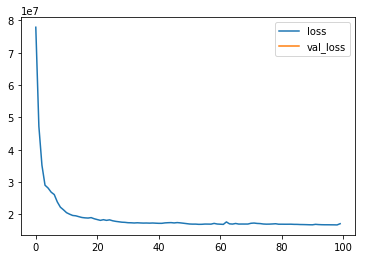

In [17]:
forecast2.fit(x_data_train, y_data_train, batch_size=100, epochs=100, verbose=1, callbacks=[plot_losses], shuffle=True)


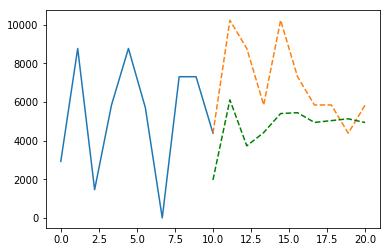

4712.85

In [61]:
# Good picks = 
sample = x_data_train[500]
sampleY = y_data_train[500]
results = forecast2.predict(np.array([sample]))

sampleX = np.linspace(0, 10, 10)
resultX = np.linspace(10, 20, 10)
plt.plot(sampleX, sample.flatten())
plt.plot(resultX, sampleY.flatten(), '--')
plt.plot(resultX, results.flatten(), 'g--')
plt.show()

np.mean(results.flatten())

In [65]:
testX, testY, _ = next_batch([bandwidths1b['192.168.8.237'].y], batch_sz=seq_len, forecast=10)
result = forecast2.predict([testX])

sampleX = np.linspace(0, 10, 10)
resultX = np.linspace(10, 20, 10)
plt.plot(sampleX, testX.flatten())
plt.plot(resultX, testY.flatten(), '--')
plt.plot(resultX, result.flatten(), 'g--')
plt.show()

NameError: name 'bandwidths1b' is not defined

# Autoencoder Attempt 1
Try to do the simple RNN matching, but this time using an autoencoder setup

In [320]:
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([1000*dataset[i].x, dataset[i].y])
    else:
        input_data.append([1000*(dataset[i].x-dataset[i-1].x), w dataset[i].y])

input_data = np.array(input_data)

seq_len = 30
x_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])

x_data = np.array(x_data)
x_data.shape # 20888 samples, 30 time steps, 2 features

x_data_train = x_data[:14621]
x_data_test = x_data[14621:]
x_data.shape

(20888, 30, 2)

In [325]:
autoencoder = Sequential()
autoencoder.add(LSTM(units=seq_len, activation='relu', input_shape=(seq_len, 2), return_sequences=True, name='layer1'))
autoencoder.add(LSTM(units=int(2*seq_len), activation='relu', name='layer2', return_sequences=True))
autoencoder.add(LSTM(units=int(2*seq_len), activation='relu', name='layer3', return_sequences=True))
autoencoder.add(LSTM(units=seq_len, activation='relu', name='layer4', return_sequences=True))
autoencoder.add(TimeDistributed(Dense(2), name="layer5"))

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3960      
_________________________________________________________________
layer2 (LSTM)                (None, 30, 60)            21840     
_________________________________________________________________
layer3 (LSTM)                (None, 30, 60)            29040     
_________________________________________________________________
layer4 (LSTM)                (None, 30, 30)            10920     
_________________________________________________________________
layer5 (TimeDistributed)     (None, 30, 2)             62        
Total params: 65,822
Trainable params: 65,822
Non-trainable params: 0
_________________________________________________________________


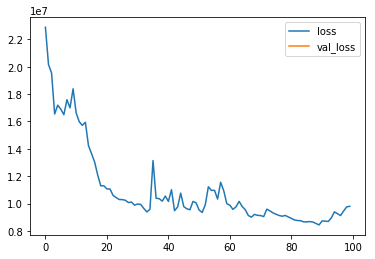

In [326]:
autoencoder.fit(x_data, x_data, batch_size=400, epochs=100, shuffle=True, callbacks=[plot_losses], verbose=1)

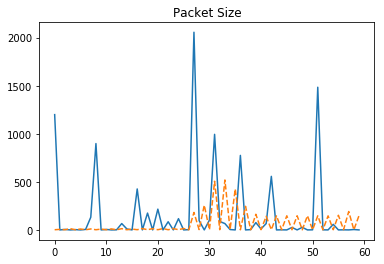

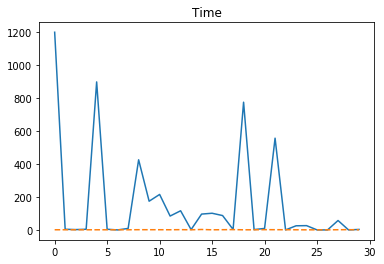

In [375]:
sample = x_data_train[0]
results = autoencoder.predict(np.array([sample]))

plt.title('Packet Size')
plt.plot(sample.flatten())
plt.plot(results.flatten(), '--')
plt.show()

plt.title('Time')
plt.plot(sample[:, 0])
plt.plot(results[0][:, 0], '--')
plt.show()

In [373]:
sample[:, 0]/1000

array([1.199e+00, 5.000e-03, 3.000e-03, 5.000e-03, 8.980e-01, 5.000e-03,
       1.000e-03, 1.000e-02, 4.260e-01, 1.750e-01, 2.160e-01, 8.500e-02,
       1.170e-01, 3.000e-03, 9.700e-02, 1.020e-01, 8.800e-02, 4.000e-03,
       7.750e-01, 3.000e-03, 1.000e-02, 5.570e-01, 1.000e-03, 2.600e-02,
       2.700e-02, 1.000e-03, 1.000e-03, 5.800e-02, 1.000e-03, 4.000e-03])

In [369]:
results[0][:, 0]

array([1.8429018, 1.9462768, 1.7959595, 1.7795527, 1.7988443, 1.8405651,
       1.8501735, 1.798414 , 2.3099086, 2.2368953, 2.1751218, 1.9601238,
       2.569446 , 1.7698255, 3.6212106, 1.6643518, 2.3233202, 2.9366608,
       1.6706451, 1.6934124, 2.5237653, 2.3370032, 2.1646004, 1.8135564,
       1.5596057, 1.5336429, 1.5322199, 2.1125808, 2.5546227, 1.5895962],
      dtype=float32)

# Autoencoder Attempt 2

In [455]:
input_data = []# [ [time_since_last_packet, length] ]

dataset = bandwidths2b['192.168.8.237']
for i, _ in enumerate(dataset):
    if i == 0:
        input_data.append([dataset[i].x, dataset[i].y])
    else:
        input_data.append([(dataset[i].x-dataset[i-1].x), dataset[i].y])

input_data = np.array(input_data)

seq_len = 30
x_data = []

for i, val in enumerate(input_data):
    if i % 5 == 0 and i+seq_len < len(input_data):
        x_data.append(input_data[i:i+seq_len])

x_data = np.array(x_data)
x_data.shape # 20888 samples, 30 time steps, 2 features

x_data_train = x_data[:14621]
x_data_test = x_data[14621:]
x_data.shape

(20888, 30, 2)

In [453]:
# Preprocess
from sklearn.preprocessing import StandardScaler
scalers = {}
for i in range(x_data_train.shape[2]):
    scalers[i] = StandardScaler()
    x_data_train[:, i, :] = scalers[i].fit_transform(x_data_train[:, i, :])

# for i in range(x_data_train.shape[2]):
#     x_data_train[:, i, :]  = scalers[i].inverse_transform(x_data_train[:, i, :])
x_data_train = x_data[:14621]
x_data_test = x_data[14621:]

In [454]:
x_data_train[0]

array([[ 1.02134860e+00, -1.44689629e+00],
       [-3.49265346e-02, -1.45360261e+00],
       [ 3.00000000e-03,  0.00000000e+00],
       [ 5.00000000e-03,  1.32000000e+02],
       [ 8.98000000e-01,  0.00000000e+00],
       [ 5.00000000e-03,  0.00000000e+00],
       [ 1.00000000e-03,  6.60000000e+01],
       [ 1.00000000e-02,  0.00000000e+00],
       [ 4.26000000e-01,  0.00000000e+00],
       [ 1.75000000e-01,  0.00000000e+00],
       [ 2.16000000e-01,  0.00000000e+00],
       [ 8.50000000e-02,  0.00000000e+00],
       [ 1.17000000e-01,  0.00000000e+00],
       [ 3.00000000e-03,  2.05600000e+03],
       [ 9.70000000e-02,  0.00000000e+00],
       [ 1.02000000e-01,  9.94000000e+02],
       [ 8.80000000e-02,  6.60000000e+01],
       [ 4.00000000e-03,  0.00000000e+00],
       [ 7.75000000e-01,  0.00000000e+00],
       [ 3.00000000e-03,  7.60000000e+01],
       [ 1.00000000e-02,  6.60000000e+01],
       [ 5.57000000e-01,  0.00000000e+00],
       [ 1.00000000e-03,  0.00000000e+00],
       [ 2.

In [456]:
x_data_train[0]

array([[1.199e+00, 0.000e+00],
       [5.000e-03, 0.000e+00],
       [3.000e-03, 0.000e+00],
       [5.000e-03, 1.320e+02],
       [8.980e-01, 0.000e+00],
       [5.000e-03, 0.000e+00],
       [1.000e-03, 6.600e+01],
       [1.000e-02, 0.000e+00],
       [4.260e-01, 0.000e+00],
       [1.750e-01, 0.000e+00],
       [2.160e-01, 0.000e+00],
       [8.500e-02, 0.000e+00],
       [1.170e-01, 0.000e+00],
       [3.000e-03, 2.056e+03],
       [9.700e-02, 0.000e+00],
       [1.020e-01, 9.940e+02],
       [8.800e-02, 6.600e+01],
       [4.000e-03, 0.000e+00],
       [7.750e-01, 0.000e+00],
       [3.000e-03, 7.600e+01],
       [1.000e-02, 6.600e+01],
       [5.570e-01, 0.000e+00],
       [1.000e-03, 0.000e+00],
       [2.600e-02, 0.000e+00],
       [2.700e-02, 0.000e+00],
       [1.000e-03, 1.484e+03],
       [1.000e-03, 0.000e+00],
       [5.800e-02, 0.000e+00],
       [1.000e-03, 0.000e+00],
       [4.000e-03, 0.000e+00]])

In [410]:
autoencoder = Sequential()
autoencoder.add(LSTM(units=seq_len, activation='relu', input_shape=(seq_len, 2), return_sequences=True, name='layer1'))
autoencoder.add(LSTM(units=int(2*seq_len), activation='relu', name='layer2', return_sequences=True))
autoencoder.add(LSTM(units=int(0.5*seq_len), activation='relu', name='layer3', return_sequences=True))
autoencoder.add(LSTM(units=int(0.5*seq_len), activation='relu', name='layer4', return_sequences=True))
autoencoder.add(LSTM(units=int(2*seq_len), activation='relu', name='layer5', return_sequences=True))
autoencoder.add(LSTM(units=seq_len, activation='relu', name='layer6', return_sequences=True))
autoencoder.add(TimeDistributed(Dense(2), name="layer7"))

autoencoder.compile(loss='mean_squared_error', optimizer='adam')
autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
layer1 (LSTM)                (None, 30, 30)            3960      
_________________________________________________________________
layer2 (LSTM)                (None, 30, 60)            21840     
_________________________________________________________________
layer3 (LSTM)                (None, 30, 15)            4560      
_________________________________________________________________
layer4 (LSTM)                (None, 30, 15)            1860      
_________________________________________________________________
layer5 (LSTM)                (None, 30, 60)            18240     
_________________________________________________________________
layer6 (LSTM)                (None, 30, 30)            10920     
_________________________________________________________________
layer7 (TimeDistributed)     (None, 30, 2)             62        
Total para

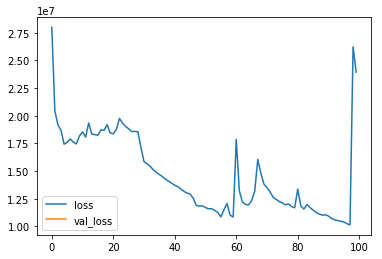

In [413]:
autoencoder.fit(x_data, x_data, batch_size=400, epochs=100, shuffle=True, callbacks=[plot_losses], verbose=1)

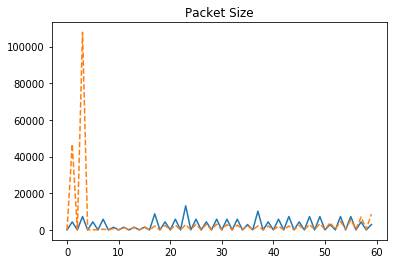

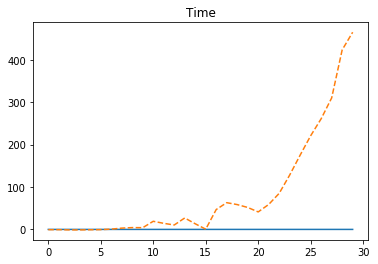

In [468]:
sample = x_data_train[200]
results = autoencoder.predict(np.array([sample]))
for i in range(results.shape[2]):
    results[:, i, :]  = scalers[i].inverse_transform(results[:, i, :])

plt.title('Packet Size')
plt.plot(sample.flatten())
plt.plot(results.flatten(), '--')
plt.show()

plt.title('Time')
plt.plot(sample[:, 0])
plt.plot(results[0][:, 0], '--')
plt.show()

In [473]:
results[:, 29, :]

array([[ 464.66537, 8613.64   ]], dtype=float32)

In [467]:
sample

array([[1.0000e-03, 2.9240e+03],
       [1.0000e-03, 8.7720e+03],
       [1.0000e-03, 1.4620e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 8.7720e+03],
       [1.0000e-03, 5.7120e+03],
       [1.2480e+00, 0.0000e+00],
       [1.0000e-03, 7.3100e+03],
       [1.0000e-03, 7.3100e+03],
       [1.0000e-03, 4.3860e+03],
       [1.0000e-03, 4.3860e+03],
       [1.0000e-03, 1.0234e+04],
       [1.0000e-03, 8.7720e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 1.0234e+04],
       [1.0000e-03, 7.3100e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 4.3860e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 4.3860e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 2.9240e+03],
       [1.0000e-03, 1.0234e+04],
       [1.0000e-03, 7.3100e+03],
       [1.0000e-03, 1.0234e+04],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 5.8480e+03],
       [1.0000e-03, 8.7720e+03]])